# Integrateur pour l'équation de la chaleur dans différents systèmes 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

import pandas as pd
import ipywidgets as ipw

from scipy.interpolate import interp1d
from scipy.linalg import expm
from bokeh.palettes import RdYlBu11
from bokeh.transform import linear_cmap
from bokeh.io import push_notebook, output_notebook, show
from bokeh.layouts import row, column
from bokeh.plotting import figure, curdoc
from bokeh.models import ColumnDataSource, ColorBar, BasicTickFormatter, BasicTicker, FixedTicker, FuncTickFormatter
from bokeh.client import push_session

from ipywidgets import interact
from ipywidgets import IntSlider, interact, FloatSlider

output_notebook()

Loading BokehJS ...

### Readme

- Les codes ci-dessous fournissent des intégrateurs pour l'équation de la chaleur en deux dimensions. 
- La fin du notebook comporte une série de questions afin de guider l'intuition du lecteur, elles ne sont évidemment pas à rendre.  
- REMARQUE: il est recommandé de compiler deux fois à l'aide de la touche 'run' les cellules comprenant du texte (voir ci-dessous) afin que les formules apparaissent. 

# L'équation de diffusion
(Run twice)

L'équation de la chaleur pour une fonction $u \in$ $\mathcal{R}^n\rightarrow \mathcal{R}$ prend la forme suivante, où $\Delta$ est l'opérateur laplacien en dimension $n$ et $a$ un réel positif, le coefficient de diffusion.

\begin{equation}
\frac{\partial u}{\partial t}(\textbf{x},t) = a\cdot\Delta u(\textbf{x},t)\label{eq1} \hspace{1cm} \forall \mathbf{x} \in \Omega
\end{equation}

L'objectif est ici d'intégrer numériquement cette équation sur le domaine $\Omega$. C'est une équation différentielle aux dérivées partielles et requiert de définir numériquement l'opérateur de Laplace, défini analytiquement comme 
$$\Delta := \sum_{\alpha} \frac{\partial^2}{\partial \alpha^2}$$

Remarque pour le lecteur intéressé: Le Laplacien est ici numériquement défini par différences finies centrées, méthode qui sera abordée au cours de physique numérique. 

## Domaine plan: Diffusion bi-dimensionnelle

- Le domaine considéré ici consiste en une grille de dimension NxN à défnir lors de l'exécution du programme.

- La définition numérique du Laplacien se trouve dans le code pour le lecteur intéressé.

- Sinon, il ne reste qu'à executer le programme, et il est recommandé de faire varier les paramètres physiques du système (coeff de diffusion, taille de la source, conditions initiales etc) afin de se familiariser avec le phénomène de diffusion.

## 1) Thermalisation de deux blocs en contact thermique
(Run twice)

- Deux blocs de métal sont mis en contact l'un avec l'autre, l'un a température $T_1$ et l'autre à température $T_2 \neq T_1$. On réalise une coupe des deux blocs, modélisée par la grille 2D NxN introduite précédemment. Les deux blocs sont constitués du même nombre de moles de métal. Le système total formé des deux blocs est supposé isolé. 

- Le code suivant vise à modéliser l'évolution temporelle du profil de température à l'interface entre les deux blocs, due à un transfert de chaleur d'un bloc à l'autre. 

- En output du code, un plot de la vue en coupe des deux blocs à 9 temps différents, idem pour le profil de température.

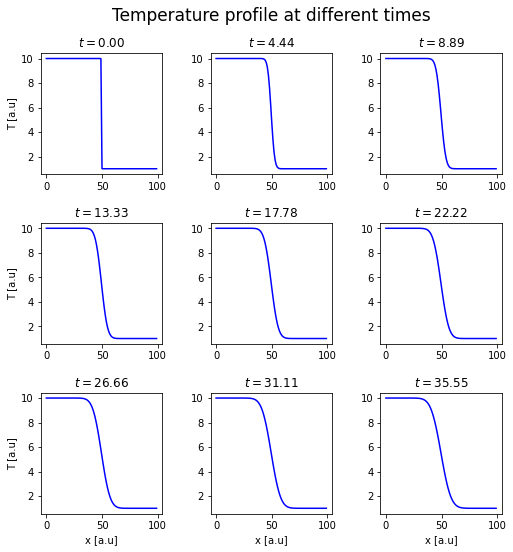

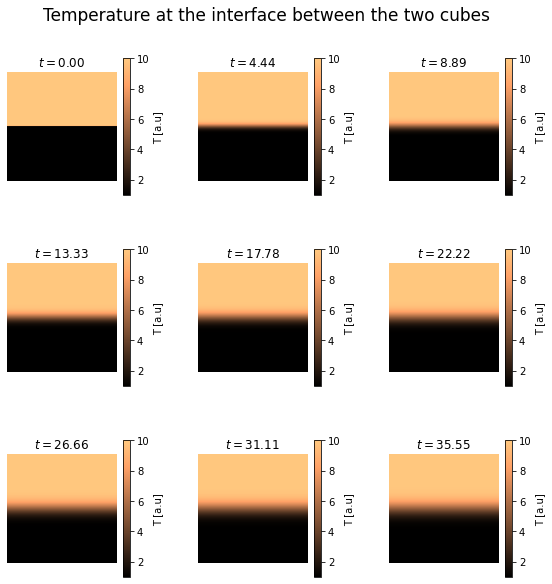

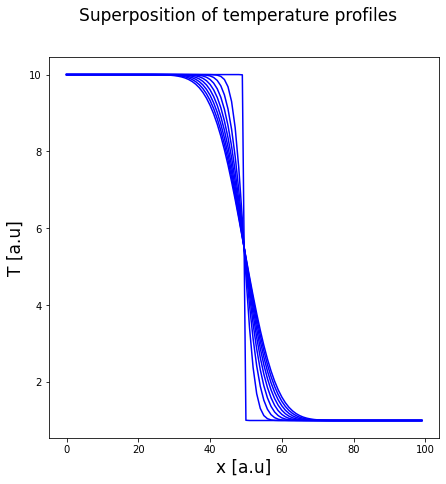

In [2]:
################################################
######    Thermalisation de deux blocs     #####
################################################

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline


########################################
######    NUMERICAL PARAMETERS     #####
########################################

# THE NUMERICAL PARAMETERS CAN BE CHANGED 

a = 2.8e-4       # Diffusion coeff 
b = 5e-3         # Turing Patterns
tau = .1         # Turing Patterns
k = -.005        # Turing Patterns

size = 100        # size of the 2D grid
dx = 2. / size    # space step
T = 40            # total time (default 40)
dt = .001         # time step
n = int(T / dt)   # number of iterations

##########################################
# Initialize a container for the profile 
# at the interface
y = np.arange(start=0, stop=size, step=1)

# Initialize a container for the temperature distribution on the grid
U = np.zeros((size, size))
V = np.zeros((size, size))
for i in range(50):
    for j in range(100):
        U[i][j]=10
        
### ^^ CHANGE VALUE of U[i,j] for T1 ^^ ###
###########################################

for i in range(50,100):
    for j in range(100):
        U[i][j]=1

### ^^ CHANGE VALUE of U[i,j] for T2 ^^ ###
###########################################



############################################
# DEF OF LAPLACIAN OPERATOR W/ FINITE DIFF #
############################################

def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2
            

#Function that displays the temperature on the grid
def show_TEMPERATURE(U, ax=None):
    graph =  ax.imshow(U, cmap=plt.cm.copper,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1])
    ax.set_xlabel('x')
    ax.set_axis_off()
    fig.colorbar(graph, ax=ax, label = 'T [a.u]')

#Function that displays the temperature profile 
def show_profile(U, ax=None):
    graph = ax.plot(y,U[:,int(size//2)], color='blue')

    

###### FIGURE TO RECEIVE TEMP PROFILE #######    
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
plt.setp(axes[-1, :], xlabel='x [a.u]')
plt.setp(axes[:, 0], ylabel='T [a.u]')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.suptitle("Temperature profile at different times" , fontsize = 17)

#### FIGURE TO RECEIVE TEMP DISTRIBUTION #####
fig, axes2 = plt.subplots(3, 3, figsize=(9, 9))
plt.setp(axes2[-1, :], xlabel='x [a.u]')
plt.setp(axes2[:, 0], ylabel='y [a.u]')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.suptitle("Temperature at the interface between the two cubes" , fontsize = 17)

##### FIG FOR TEMP_PROFILE CUMUL ######
fig, axes3 = plt.subplots(1,1, figsize=(7, 7))
plt.xlabel('x [a.u]', fontsize = 17)
plt.ylabel('T [a.u]', fontsize = 17)
#plt.setp(axes3, xlabel='x [a.u]')
#plt.setp(axes3, ylabel='T [a.u]')
fig.suptitle("Superposition of temperature profiles" , fontsize = 17)

##### FIG FOR TEMP_PROFILE CURSOR ######
#fig, axes4 = plt.subplots(1,1, figsize=(8, 8))

step_plot = n // 9
   

##################################################
# We solve the PDE with finite differences       #
##################################################
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
         
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    # We update the variables.
    U[1:-1, 1:-1]= \
        Uc + dt * (a * deltaU )
      
    # Neumann conditions: derivatives at the edges
    # are null. (ZERO GRADIENT AT THE BOUNDARY)
    for Z in (U, V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 9 * step_plot:
        ax = axes.flat[i // step_plot]
        ax2 = axes2.flat[i // step_plot]
        ax3 = axes3
        show_profile(U,ax=ax)
        ax.set_title(f'$t={i * dt:.2f}$')
        show_TEMPERATURE(U, ax=ax2)
        ax2.set_title(f'$t={i * dt:.2f}$')
        show_profile(U,ax=ax3)
        #ax3.legend(axes3, loc='ll', label='legend label')
        
        
## PLOT THE FINAL TEMPERATURE DISTRIBUTION ## 
#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#show_TEMPERATURE(U, ax=ax)

## PLOT THE FINAL TEMPERATURE PROFILE AT THE STEP ## 
#fig, ax2 = plt.subplots(1, 1, figsize=(7, 7))
#show_profile(U, ax=ax2)

plt.show()

## 2) Diffusion bi-dimensionnelle d'une source chaude

- Ici, une source chaude à température $T_1$ diffuse sur une grille de dimension $N\times N$, le reste de l'espace étant à température $T_2<T_1$.

- La source est plus ou moins localisée, son étendue spatiale est à définir. Le lecteur peut se familiariser avec le code en changeant les paramètres, il est cependant recommandé de prendre un nombre de points de maillage de l'ordre de $10^2$ pour un temps d'execution correct. 

Please enter an (even) integer - Size of the 2D grid (recommended: 100):
 100
Give the temperature of the heat source (in arbitrary units - recommended: 10):
 10
Simulation time (recommended: about 20 to 40):
 10
Please enter an integer < N/2 - half range of the heat source (the more narrow, the more the initial distribution looks like a delta function): 
 1


Width of the heat source: 2 meshpoints


Diffusion coefficient - order of 10-4 to 10-6 recommended (recommended 3e-4):
 1e-4


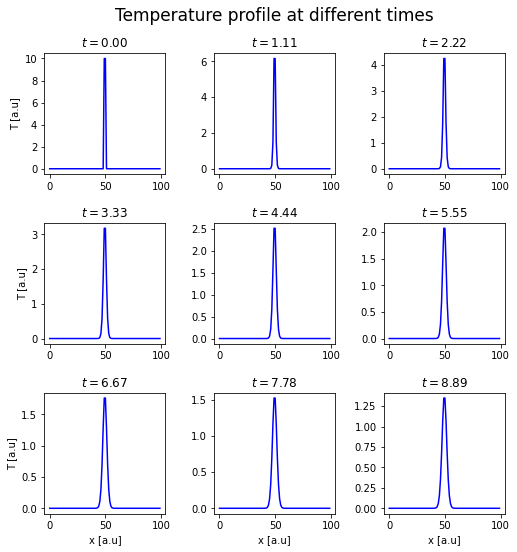

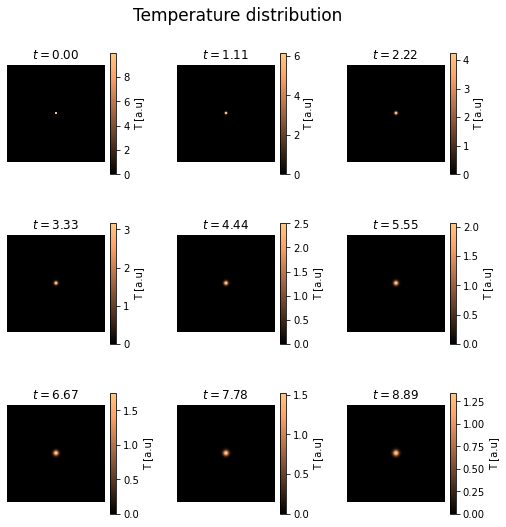

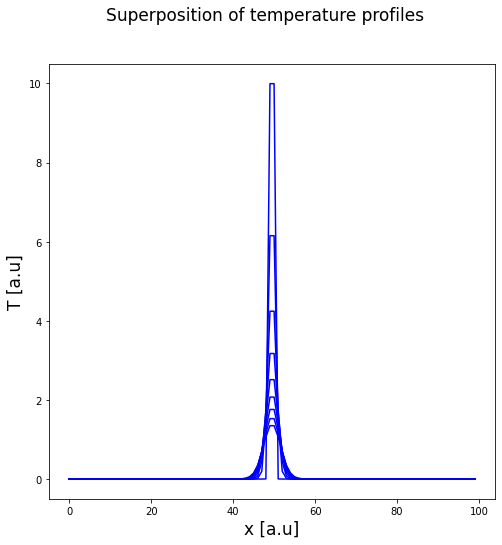

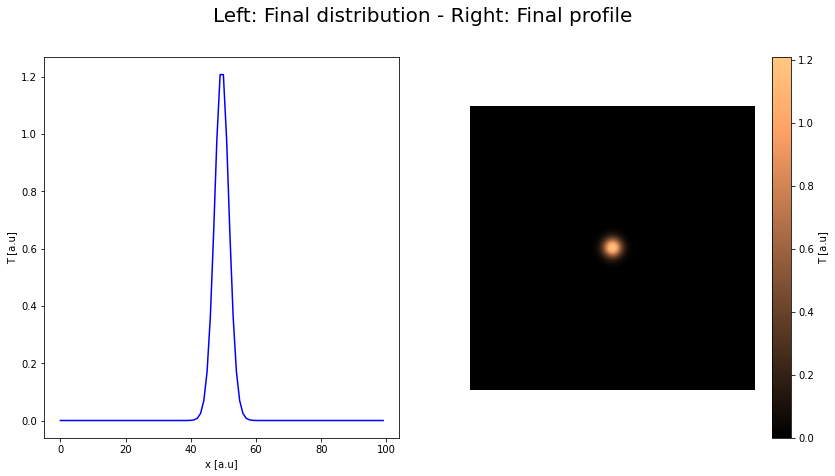

In [7]:
########################################
# HEAT DIFFUSION ON A 2D SQUARE DOMAIN #
########################################


#Defines the parameters of the simulation#
##########################################


######### size of the 2D grid ###########
lect_size = input("Please enter an (even) integer - Size of the 2D grid (recommended: 100):\n")
size = int(lect_size)  
dx = 2. / size  # space step

#Initialize a container for heat distribution
U = np.zeros((size, size))
V = np.zeros((size, size))

#Initialize the temperature of the heat source 
temp = input("Give the temperature of the heat source (in arbitrary units - recommended: 10):\n")

######### simulation time  ###########
lect_time = input("Simulation time (recommended: about 20 to 40):\n")
T = float(lect_time)  # total time
dt = .001  # time step small enough to ensure stability of the numerical scheme 
n = int(T / dt)  # number of iterations

x = np.arange(start=0, stop=size, step=1)

########### Initial heat distribution - square source ############
lect = input("Please enter an integer < N/2 - half range of the heat source (the more narrow, the more the initial distribution looks like a delta function): \n")
value = int(lect)
print(f'Width of the heat source: {2*value} meshpoints')

length = float(size)
for i in range (int(length/2)-value,int(length/2)+value):
    for j in range (int(length/2)-value,int(length/2)+value):
        U[i][j]=temp
        

############### Diffusion coefficient a ####################
lect_a = input("Diffusion coefficient - order of 10-4 to 10-6 recommended (recommended 3e-4):\n") # diffusion coefficient
a = float(lect_a)
#a = 2.8e-4 # diffusion coefficient


############################################
# DEF OF LAPLACIAN OPERATOR W/ FINITE DIFF #
############################################


def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

####################################################
#Function that displays the temperature on the grid#
def show_temperature(U, ax=None):
    graph = ax.imshow(U, cmap=plt.cm.copper,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1])
    ax.set_axis_off()
    fig.colorbar(graph, ax=ax, label = 'T [a.u]')
    
    
def show_profile(U, ax=None):
    graph = ax.plot(x,U[:,int(size//2)], color='blue')

    
step_plot = n // 9    
    

####  CREATES A CURSOR TO CHANGE TIME  ######
#@interact(t = IntSlider(min = 0, max = n, value=n))
#def affiche_t(t): 
#    if t % step_plot == 0 and t < 9 * step_plot:
#        ax = axes.flat[int(t*dt) // step_plot]
#        show_profile(U, ax=ax)
#        plt.title("temperature vs t")
#       plt.show()

#@interact(t = IntSlider(min = 0, max = T, value=n))
#def affiche_t(t): 
#    if t % step_plot == 0 and t < 9 * step_plot:
#        ax = axes.flat[t // step_plot]
#        show_temperature(U, ax=ax)
#        plt.title("temperature vs t")
#        plt.show()


   
    
    
###### FIGURE TO RECEIVE TEMP PROFILE #######    
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
plt.setp(axes[-1, :], xlabel='x [a.u]')
plt.setp(axes[:, 0], ylabel='T [a.u]')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


fig.suptitle("Temperature profile at different times" , fontsize = 17)

#### FIGURE TO RECEIVE TEMP DISTRIBUTION #####
fig, axes2 = plt.subplots(3, 3, figsize=(8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.suptitle("Temperature distribution" , fontsize = 17)

##### FIG FOR TEMP_PROFILE CUMUL ######
fig, axes3 = plt.subplots(1,1, figsize=(8, 8))
plt.xlabel('x [a.u]', fontsize = 17)
plt.ylabel('T [a.u]', fontsize = 17)
fig.suptitle("Superposition of temperature profiles" , fontsize = 17)

step_plot = n // 9
##################################################
# We solve the PDE with finite differences       #
##################################################

for i in range(n):
    # We compute the Laplacian of u.
    deltaU = laplacian(U)
    
    # We take the values of u inside the grid.
    Uc = U[1:-1, 1:-1]

    # We update the variables.
    U[1:-1, 1:-1] = Uc + dt * (a * deltaU)
    
    
    # Neumann conditions: derivatives at the edges
    # are null (values at the boundary are set constant)
    for Z in (U,V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 9 * step_plot:
        ax = axes.flat[i // step_plot]
        ax2 = axes2.flat[i // step_plot]
        ax3 = axes3
        show_profile(U,ax=ax)
        ax.set_title(f'$t={i * dt:.2f}$')
        show_TEMPERATURE(U, ax=ax2)
        ax2.set_title(f'$t={i * dt:.2f}$')
        show_profile(U,ax=ax3)
        #ax.set_title(f'$t={i * dt:.2f}$')
    
        
## PLOT THE FINAL TEMPERATURE DISTRIBUTION ## 
fig, ax = plt.subplots(1, 2, figsize=(14,7))
fig.suptitle("Left: Final distribution - Right: Final profile" , fontsize = 20)
show_profile(U, ax=ax[0])
plt.setp(ax[0], xlabel='x [a.u]')
plt.setp(ax[0], ylabel='T [a.u]')
show_temperature(U, ax=ax[1])


## PLOT THE FINAL TEMPERATURE PROFILE AT THE STEP ## 
#fig, ax2 = plt.subplots(1, 1, figsize=(7, 7))
#show_profile(U, ax=ax2)

#####################################################
#List of parameters to save 
#100, 40, 5, 1e-4

plt.show()

# QUESTIONS 
En répondant aux questions ci-dessous, penser à une réponse et modifier ensuite le code (lorsque c'est possible) afin de vérifier le résultat. Les réponses seront affichées dans la cellule suivante

- Dans le cas de la thermalisation des deux blocs, quelle serait la forme du profil lorsque $t\rightarrow \infty$ ?
- Determiner la valeur de la température à l'équilibre (i.e pour $t\rightarrow \infty$), en fonction de $T_i$, $i=1,2$, sachant le nombre de moles de métal dans les deux blocs identique. Le résultat est-il surprenant ? Quel(s) paramètres pourrait-on changer pour obtenir un résultat différent ? 

- Dans le cas de la source ponctuelle, l'aire sous le profil de température est-elle sensée être une constante ? Si oui pourquoi ? Dans ce cas, les résultats sont-ils en accord avec vos prédiction ? Si non, à votre avis pourquoi ? 
- Peut-on déterminer le rayon de la tache de diffusion de la source ponctuelle à un temps t> 0


## REPONSES

- Pour des temps très longs, on s'attend à ce que le profil de température devienne un profil constant, à température $T$, situation caractéristique de l'équilibre thermodynamique entre deux sous-systèmes simples, rigides, et en contact thermique l'un avec l'autre. 
- On s'attend à une température d'équilibre $T=\frac{T_1+T_2}{2}$. (Voir exercice 3.4). Pour un résultat différent, on pourrait par exemple modifier les nombres de moles $N_i$ propres à chaque blocs, et dans ce cas: $$T=\frac{N_1 T_1+N_2 T_2}{N_1+N_2}$$
- Le système total (formé des deux blocs) étant isolé, la puissance thermique vers l'extérieur du système est sensée être nulle. On observe que l'aire sous la courbe de température diminue au cours du temps. Ce phénomène de dissipation d'énergie est nullement physique mais est dû au fait que le schéma numérique utilisé pour résoudre l'équation de diffusion est non conservatif. 
